# Introduction

A support vector machine (SVM) is a type of machine learning algorithm. It's purpose is to do classification problems. It can handle continuous and categorical variables.
The classification method is to construct a hyperplane in multidimensional space to separate different classes.
SVM generates this hyperplane iteratively, trying to minimize the error.

<img src="https://openclipart.org/image/2400px/svg_to_png/182977/svm1.png" alt="Support Vector Machine Diagram" style="max-height: 300px;"/>

# Data

First, a dataset must be prepared. In this example, the Breast Cancer Wisconsin dataset is used. This is a dataset provided by scikit learn.

The data has 30 features (mean radius, mean texture, ....), and is classified in two ways, malignant and benign.

First, some python packages must be imported to do the dataprocessing with.

In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

With these packages, the dataset can now be loaded.

In [2]:
def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']
    
    # First the dataset must be imported.
    cancer = datasets.load_breast_cancer()
    
    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)
    
    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]
            
            label = 'Malignant' if k is 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()
        

    return X_train, training_input, test_input, class_labels

# Algorithm Preperation

With the dataset prepared, the dataset can now be used.
Here, the data is split up so that the algorithm input can be generated.

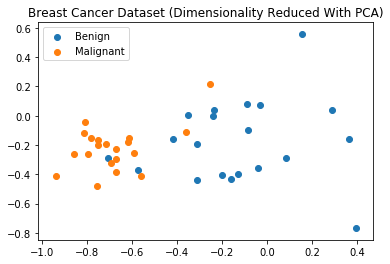

{'Benign': 0, 'Malignant': 1}


In [3]:
from qiskit_aqua.utils import split_dataset_to_data_and_labels

n = 2 # How many features to use (dimensionality)
training_dataset_size = 20
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)


The algorithm inputs are initialized before.
To build the Support Vector Machine, a feature map has to be initialized.

It is in this section that QCGPU, the software developed in this project is used. Because of the integration with IBM's software, it can be used seamlessly instead of there simulation backend, providing a speedup.

This speedup means that algorithms such as this can be tested quicker, allowing for faster prototyping and thus better algorithms overall.

In [5]:
from qiskit_aqua.input import SVMInput
from qiskit_qcgpu_provider import QCGPUProvider
from qiskit_aqua import run_algorithm

params = {
    'problem': {'name': 'svm_classification', 'random_seed': 10598},
    'algorithm': { 'name': 'QSVM.Kernel' },
    'backend': {'name': 'qasm_simulator', 'shots': 1024},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'}
}

backend = QCGPUProvider().get_backend('qasm_simulator')

algo_input = SVMInput(training_input, test_input, datapoints[0])
%time result = run_algorithm(params, algo_input)
%time result = run_algorithm(params, algo_input, backend=backend)

CPU times: user 1min 10s, sys: 4.27 s, total: 1min 15s
Wall time: 1min 46s
CPU times: user 1min 2s, sys: 5.27 s, total: 1min 7s
Wall time: 1min 30s


# Running The Algorithm

With everything setup, the algorithm can now be run.
The run method does everything, including the training testing 
and prediciton on unlabeled data. We can also find data such as the
success ratio.

The trained model is stored in the `svm` variable.
This is them used to predict some datapoints, which is then analyzed in the next section

In [6]:
print("ground truth:    {}".format(datapoints[1]))
print("prediction:      {}".format(result['predicted_labels']))
print("predicted class: {}".format(result['predicted_classes']))
print("accuracy:        {}".format(result['testing_accuracy']))

ground truth:    [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction:      [0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 1]
predicted class: ['Benign', 'Malignant', 'Benign', 'Benign', 'Benign', 'Malignant', 'Benign', 'Benign', 'Malignant', 'Benign', 'Malignant', 'Malignant', 'Benign', 'Malignant', 'Malignant', 'Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant']
accuracy:        0.75
